In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AMZN_2006-01-01_to_2018-01-01.csv to AMZN_2006-01-01_to_2018-01-01.csv


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Dec  4 18:26:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, SimpleRNN
from keras.optimizers import RMSprop

In [ ]:
data = pd.read_csv("AMZN_2006-01-01_to_2018-01-01.csv", parse_dates = ['Date'], index_col = 'Date')
del data['Name']
data = data.resample('B').ffill()
data

,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127
2006-01-04,47.48,47.73,46.69,47.25,7440914
2006-01-05,47.16,48.20,47.11,47.65,5417258
2006-01-06,47.97,48.58,47.32,47.87,6154285
2006-01-09,46.55,47.10,46.40,47.08,8945056
...,...,...,...,...,...
2017-12-25,1172.08,1174.62,1167.83,1168.36,1585054
2017-12-26,1168.36,1178.32,1160.55,1176.76,2005187
2017-12-27,1179.91,1187.29,1175.61,1182.26,1867208


In [ ]:
SEED = 1420
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
def lstm_model(X, y, learn_rate, dropout):
    model = Sequential()
    model.add(LSTM(X.shape[1], return_sequences = False, input_shape=(X.shape[1:])))
    model.add(Dense(X.shape[1]))
    model.add(Dropout(dropout))
    model.add(Dense(y.shape[1], activation='tanh'))
    optimizer = RMSprop(learning_rate=learn_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.summary()
    return model


def rnn_model(X, y, learn_rate, dropout):
    model = Sequential()
    model.add(SimpleRNN(units=X.shape[1], input_shape=(X.shape[1], X.shape[2]), return_sequences=False))
    model.add(Dense(X.shape[1]))
    model.add(Dropout(dropout))
    model.add(Dense(y.shape[1], activation='tanh'))

    optimizer = RMSprop(learning_rate=learn_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    model.summary()
    return model

In [ ]:
def scale_data(data, index, scalertype):
    if scalertype == "minmax01": #minmax(0,1)
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(data)
    elif scalertype == "minmax-11": # minmax(-1, 1)
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaled_data = scaler.fit_transform(data)
    elif scalertype == "standard": #standardization
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data)
    scaled_data = pd.DataFrame({'Open': scaled_data[:, 0], 'High': scaled_data[:, 1], 'Low': scaled_data[:, 2], 'Close': scaled_data[:, 3]}, index=index)
    return scaled_data


def sequence_data(data_normal, window_size, target_length):
    close = data_normal["Close"].values
    open = data_normal["Open"].values
    high = data_normal["High"].values
    low = data_normal["Low"].values
    X = []
    y = []
    pointer = 0
    data_length = len(close)
    while (pointer + window_size + target_length) <= data_length:
        x_close = close[pointer : pointer + window_size].reshape(-1, 1)
        x_open = open[pointer : pointer + window_size].reshape(-1, 1)
        x_high = high[pointer : pointer + window_size].reshape(-1, 1)
        x_low = low[pointer : pointer + window_size].reshape(-1, 1)
        x_ = np.append(x_close, x_open, axis=1)
        x_ = np.append(x_, x_high, axis=1)
        x_ = np.append(x_, x_low, axis=1)
        X.append(x_)
        y.append(close[pointer + window_size : pointer + window_size + target_length])
        pointer += 1
    X = np.asarray(X)
    y = np.asarray(y)
    return X, y


def split_data(X, y, split_rate=0.2):
    split = int(len(X) * (1 - split_rate))
    X_train = X[:split, :]
    y_train = y[:split]
    X_test = X[split:, :]
    y_test = y[split:]
    return X_train, y_train, X_test, y_test

In [ ]:
window_sizes = [100, 150, 250]
dropouts = [0.0, 0.25, 0.4]
learn_rates = [0.1, 0.01, 0.001]
epochs = [500]
batch_sizes = [32]
scaling = ["minmax01"]

# window_sizes = [100]
# dropouts = [0.25, 0.5]
# learn_rates = [0.01]
# epochs = [100, 200, 500]
# batch_sizes = [32, 64, 128]
# scaling = ["minmax01", "minmax-11", "standard"]

# window_sizes = [100]
# dropouts = [0.25]
# learn_rates = [0.001]
# epochs = [500]
# batch_sizes = [32]
# scaling = ["minmax01"]

results_list = []


def best_model(data, window_sizes, learn_rates, dropouts, epochs, batch_size, scaling):
    #our best model variables
    best_model = None
    lowest_test_error = 2.0
    best_training_error =0.0
    best_learn_rate = 0.0
    best_dropout_rate = 0.0
    best_epoch = 0
    best_window_size = 0

    counter = 1

    for sc in scaling:
        normalized_data = scale_data(data, data.index, sc)

        for window_size in window_sizes:
            print("\nWindow size: {}".format(window_size))
            print('-'* 40)

            # Prepare our sequence data
            X, y = sequence_data(normalized_data, window_size, 1)
            X_train, y_train, X_test, y_test = split_data(X, y, split_rate=0.2)

            for rate in learn_rates:
                print("\n   Learning Rate: {}".format(rate))
                print('   *'* 30)
                for dropout in dropouts:
                    print("\n      Dropout Rate: {}".format(dropout))
                    print('      ='* 20)
                    for epoch in epochs:

                        print("\n         Epochs: {}".format(epoch))
                        print('         +'* 10)
                        for batch_size in batch_sizes:
                            with tf.device("/device:gpu:1"):
                                model = rnn_model(X_train, y_train, rate, dropout)
                                model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, verbose=0)

                                # Print out training and testing errors
                                training_error = model.evaluate(X_train, y_train, verbose=0)
                                testing_error = model.evaluate(X_test, y_test, verbose=0)
                                msg = " > Scaling: {} Window size: {} Learn rate: {:.4f} Dropout: {:.2f} Epoch: {} Batch size: {} Training error: {:.4f} Testing error: {:.4f}"
                                msg = msg.format(sc, window_size, rate, dropout, epoch, batch_size, training_error, testing_error)
                                print(msg)

                                # Store the results in a list
                                result_dict = {
                                    "Scaling": sc,
                                    "Window_Size": window_size,
                                    "Learn_Rate": rate,
                                    "Dropout": dropout,
                                    "Epoch": epoch,
                                    "Batch_Size": batch_size,
                                    "Training_Error": training_error,
                                    "Testing_Error": testing_error
                                }
                                results_list.append(result_dict)

                                #check if test error
                                if lowest_test_error > testing_error:
                                    best_model = model
                                    lowest_test_error = testing_error
                                    best_learn_rate = rate
                                    best_dropout_rate = dropout
                                    best_epoch = epoch
                                    best_training_error = training_error
                                    best_window_size = window_size

                                #increase our print counter
                                counter += 1
    best_dict ={}
    best_dict["model"] = best_model
    best_dict["test_error"] =   "{0:.4f}".format(lowest_test_error)
    best_dict["learn_rate"] = best_learn_rate
    best_dict["dropout"] = best_dropout_rate
    best_dict["epoch"] = best_epoch
    best_dict["train_error"] =  "{0:.4f}".format(best_training_error)
    best_dict["window_size"] = best_window_size

    return best_dict, results_list

best_dict, results_list = best_model(data, window_sizes, learn_rates, dropouts, epochs, batch_sizes, scaling)
# Create a Pandas DataFrame from the results list
results_df = pd.DataFrame(results_list)
results_df.to_csv("lstm_results", index=False, encoding="latin1")


Window size: 100
----------------------------------------

   Learning Rate: 0.1
   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *

      Dropout Rate: 0.0
      =      =      =      =      =      =      =      =      =      =      =      =      =      =      =      =      =      =      =      =

         Epochs: 500
         +         +         +         +         +         +         +         +         +         +
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 100)               10500     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                        

In [ ]:
normalized_data = scale_data(data, data.index, "minmax01")
X, y = sequence_data(normalized_data, 100, 1)
X_train, y_train, X_test, y_test = split_data(X, y, split_rate=0.2)
with tf.device("/device:gpu:1"):
    model = lstm_model(X_train, y_train, 0.001, 0.25)
    model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=0)
    # Print out training and testing errors
    # training_error = model.evaluate(X_train, y_train, verbose=0)
    # testing_error = model.evaluate(X_test, y_test, verbose=0)
    model.predict(X_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42000     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 52201 (203.91 KB)
Trainable params: 52201 (203.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
76/76 [==============================] - 1s 3ms/step


In [ ]:
h = model.predict(X_train)

76/76 [==============================] - 0s 3ms/step


In [ ]:
h.shape

(2423, 1)

In [ ]:
j = model.predict(X_test)

19/19 [==============================] - 0s 3ms/step


In [ ]:
j.shape

(606, 1)

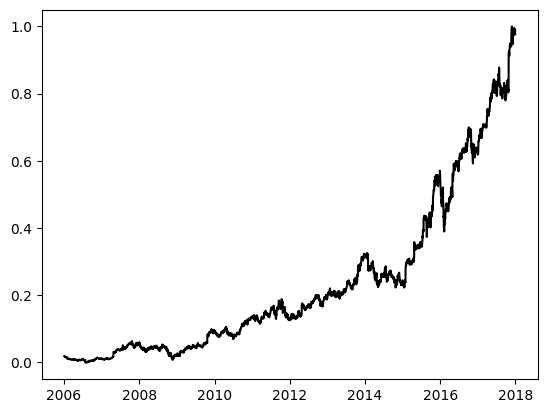

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
scaled_data = pd.DataFrame({'Close': scaled_data[:, 0]}, index=data.index)
plt.plot(scaled_data['Close'], color='k')

In [ ]:
data_index_subset = data.index[100:]

# Concatenate arrays h and j row-wise
result_array = np.concatenate((h, j), axis=0)
result_array = scaler.inverse_transform(result_array)
# Create a DataFrame with the concatenated array and data_index_subset as index
result_df = pd.DataFrame(result_array, index=data_index_subset, columns=['combined_column'])

# Display the resulting DataFrame
result_df.shape

(3029, 1)

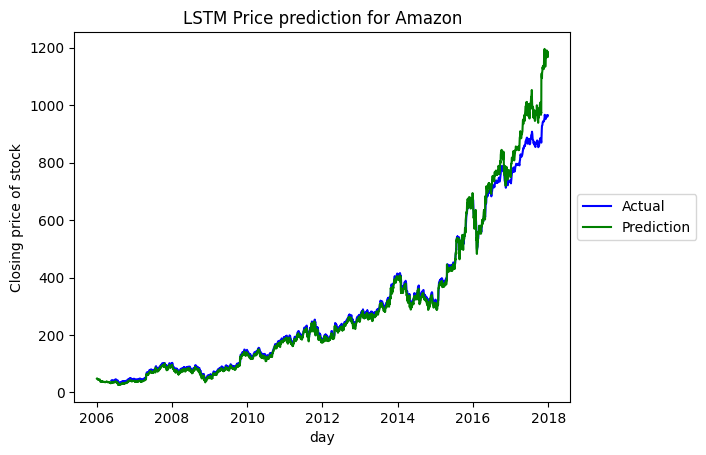

In [ ]:
plt.plot(result_df, color = 'b')
plt.plot(data['Close'], color='g')
plt.xlabel('day')
plt.ylabel('Closing price of stock')
plt.title("LSTM Price prediction for Amazon")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
data['Close'].loc["2006-05-23":,].shape  #head(100)

(3029,)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
mae = mean_absolute_error(data['Close'].loc["2006-05-23":,], result_df)
mse = mean_squared_error(data['Close'].loc["2006-05-23":,], result_df)
rmse = np.sqrt(mse) # or mse**(0.5)
r2 = r2_score(data['Close'].loc["2006-05-23":,], result_df)
mape = mean_absolute_percentage_error(data['Close'].loc["2006-05-23":,], result_df)
print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)
print("MAPE:",mape)

Results of sklearn.metrics:
MAE: 19.006173365112183
MSE: 1416.6719287714548
RMSE: 37.63870253836408
R-Squared: 0.9819517864007813
MAPE: 0.07194007293059526


# RNN

In [ ]:
normalized_data = scale_data(data, data.index, "minmax01")
X, y = sequence_data(normalized_data, 100, 1)
X_train, y_train, X_test, y_test = split_data(X, y, split_rate=0.2)
with tf.device("/device:gpu:1"):
    model = rnn_model(X_train, y_train, 0.001, 0.25)
    model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               10500     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 20701 (80.86 KB)
Trainable params: 20701 (80.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
h = model.predict(X_train)
j = model.predict(X_test)

19/19 [==============================] - 0s 8ms/step


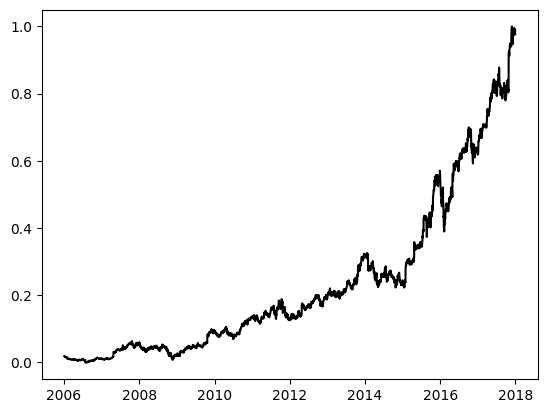

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
scaled_data = pd.DataFrame({'Close': scaled_data[:, 0]}, index=data.index)
plt.plot(scaled_data['Close'], color='k')

In [ ]:
data_index_subset = data.index[100:]

# Concatenate arrays h and j row-wise
result_array = np.concatenate((h, j), axis=0)
result_array = scaler.inverse_transform(result_array)
# Create a DataFrame with the concatenated array and data_index_subset as index
result_df = pd.DataFrame(result_array, index=data_index_subset, columns=['combined_column'])

# Display the resulting DataFrame
result_df.shape

(3029, 1)

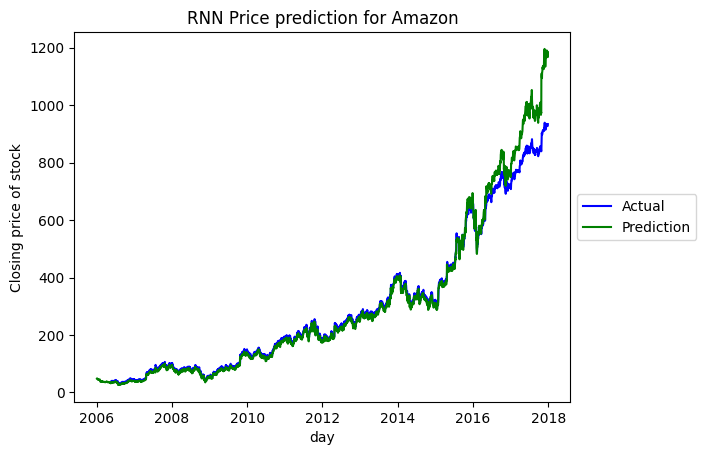

In [ ]:
plt.plot(result_df, color = 'b')
plt.plot(data['Close'], color='g')
plt.xlabel('day')
plt.ylabel('Closing price of stock')
plt.title("RNN Price prediction for Amazon")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
mae = mean_absolute_error(data['Close'].loc["2006-05-23":,], result_df)
mse = mean_squared_error(data['Close'].loc["2006-05-23":,], result_df)
rmse = np.sqrt(mse) # or mse**(0.5)
r2 = r2_score(data['Close'].loc["2006-05-23":,], result_df)
mape = mean_absolute_percentage_error(data['Close'].loc["2006-05-23":,], result_df)
print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)
print("MAPE:",mape)

Results of sklearn.metrics:
MAE: 21.05806817010355
MSE: 2045.9303722175453
RMSE: 45.23196184356307
R-Squared: 0.9739351167924014
MAPE: 0.06219412446651943
